corr of first 7:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000  0.998  0.997  0.997  0.997  0.997  0.997
X2  0.998  1.000  0.997  0.997  0.997  0.997  0.997
X3  0.997  0.997  1.000  0.997  0.997  0.997  0.997
X4  0.997  0.997  0.997  1.000  0.998  0.997  0.997
X5  0.997  0.997  0.997  0.998  1.000  0.997  0.997
X6  0.997  0.997  0.997  0.997  0.997  1.000  0.997
X7  0.997  0.997  0.997  0.997  0.997  0.997  1.000
shape: (2000, 10)   samples: 2000   feats: 10

Top (low cost, hi r2):
   lr  alpha  final_cost       r2      mse  iters
0.050  0.000    0.121069 0.999538 0.244446   5000
0.050  0.001    0.121093 0.999538 0.244446   5000
0.050  0.010    0.121302 0.999538 0.244443   5000
0.010  0.000    0.121321 0.999539 0.243998   5000
0.010  0.001    0.121345 0.999539 0.243998   5000
0.001  0.000    0.121439 0.999539 0.243800   5000
0.001  0.001    0.121462 0.999539 0.243800   5000
0.010  0.010    0.121554 0.999539 0.243996   5000

Best:
 lr=0.05  alpha=0.0  cost=0.121069  R2=0

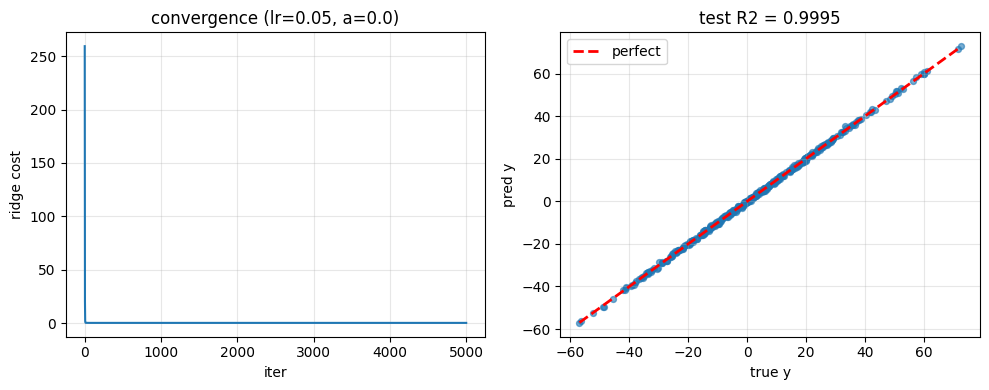


coef (bias unpenalized):
 w0 = 0.6621
 w01 = 3.2411
 w02 = 3.2331
 w03 = 3.3981
 w04 = 3.3494
 w05 = 3.0917
 w06 = 3.1129
 w07 = 3.3616
 w08 = 0.3944
 w09 = -0.1973
 w10 = -0.0002


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(42)

# ------- generate dataset  -------
n = 2000
z = np.random.normal(0,1,size=n)   # latent thing to make highly corr

# 7 highly corr features (each ~ z + small noise)
X_corr = np.column_stack([z + np.random.normal(0,0.05,size=n) for _ in range(7)])

# 3 extra noisy features ( not really helpful )
X_extra = np.column_stack([np.random.normal(0,1,size=n) for _ in range(3)])

X = np.hstack([X_corr, X_extra])

# true coefs : bigger for corr block, tiny-ish for extras
true_w = np.array([3.4,3.2,3.3,3.1,3.5,3.0,3.6, 0.4,-0.2,0.0])
y = X @ true_w + np.random.normal(0,0.5,size=n)  # lil noise

cols = [f"X{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df["y"] = y

print("corr of first 7:")
print(df[cols[:7]].corr().round(3))
print("shape:", X.shape, "  samples:", n, "  feats:", X.shape[1])

# ------- split -------
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# standarize 1st (only train stats).. avoids leakage
mu = X_tr.mean(axis=0) ; sd = X_tr.std(axis=0, ddof=0)
sd[sd==0] = 1.0
Xtr = (X_tr - mu)/sd
Xte = (X_te - mu)/sd

# add bias (intercept not reguarlized)
def add_bias(A):
    return np.hstack([np.ones((A.shape[0],1)), A])

Xtr_b = add_bias(Xtr)
Xte_b = add_bias(Xte)

# ------- ridge loss & grad  -------
def ridge_loss_grad(w, Xb, y, alpha):
    # J = (1/2n)||Xb w - y||^2 + (alpha/2n)||w[1:]||^2   (bias not penalized)
    n = Xb.shape[0]
    r = Xb @ w - y
    loss = 0.5/n * np.sum(r*r) + 0.5*alpha/n * np.sum(w[1:]**2)
    g = (Xb.T @ r)/n
    g[1:] += (alpha/n) * w[1:]
    return loss, g

# ------- grad desc loop -------
def ridge_gd(Xb, y, alpha=1e-2, lr=1e-2, max_iter=3000, tol=1e-8, verbose=False):
    n, d = Xb.shape
    w = np.zeros(d)
    costs = []
    for it in range(max_iter):
        loss, g = ridge_loss_grad(w, Xb, y, alpha)
        w -= lr* g
        costs.append(loss)
        if it>0 and abs(costs[-1]-costs[-2])<tol:
            if verbose:
                print("converged at", it)
            break
    return w, costs

# ------- small grid search -------
lrs = [0.001, 0.01, 0.05]
alphas = [0, 1e-3, 0.01, 0.1, 1, 10]

rows = []
for lr in lrs:
    for a in alphas:
        w, costs = ridge_gd(Xtr_b, y_tr, alpha=a, lr=lr, max_iter=5000, tol=1e-9, verbose=False)
        yp = Xte_b @ w
        r2 = r2_score(y_te, yp)
        mse = mean_squared_error(y_te, yp)
        rows.append({
            "lr": lr, "alpha": a,
            "final_cost": costs[-1],
            "r2": r2, "mse": mse,
            "iters": len(costs),
            "w": w, "costs": costs
        })

res = pd.DataFrame(rows)
# choose by min cost (ridge obj); if tie, use higher R2
res_best = res.sort_values(by=["final_cost","r2"], ascending=[True,False]).reset_index(drop=True)

print("\nTop (low cost, hi r2):")
print(res_best.head(8)[["lr","alpha","final_cost","r2","mse","iters"]].to_string(index=False))

best = res_best.iloc[0]
print("\nBest:")
print(f" lr={best.lr}  alpha={best.alpha}  cost={best.final_cost:.6f}  R2={best.r2:.4f}  MSE={best.mse:.4f}")

# retrain best (for plots)
w_best, costs_best = ridge_gd(Xtr_b, y_tr, alpha=float(best.alpha), lr=float(best.lr),
                              max_iter=5000, tol=1e-9, verbose=True)

# ------- plots (simple) -------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(costs_best)
plt.xlabel("iter") ; plt.ylabel("ridge cost")
plt.title(f"convergence (lr={best.lr}, a={best.alpha})")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
y_pred = Xte_b @ w_best
m1, m2 = y_te.min(), y_te.max()
plt.scatter(y_te, y_pred, s=18, alpha=0.6)
plt.plot([m1,m2],[m1,m2],"r--",lw=2,label="perfect")
plt.xlabel("true y") ; plt.ylabel("pred y")
plt.title(f"test R2 = {r2_score(y_te, y_pred):.4f}")
plt.legend() ; plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ------- report coef  -------
print("\ncoef (bias unpenalized):")
print(f" w0 = {w_best[0]:.4f}")
for i,c in enumerate(w_best[1:], start=1):
    print(f" w{i:02d} = {c:.4f}")

In [4]:
# install missing package in the notebook environment (fixes ModuleNotFoundError)
%pip install statsmodels

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# ---- load data ----
# from ISLR package via statsmodels datasets
df = sm.datasets.get_rdataset("Hitters","ISLR").data
df = df.dropna().copy()     # drop nulls (salary has NAs), copy to be safe

# ---- encode categoricals (simple codes) ----
for c in df.select_dtypes(include=["object"]).columns:
    df.loc[:, c] = pd.Categorical(df[c]).codes   # easy label codes (ok for linear models)

# ---- split X / y and scale ----
y = df["Salary"].values
X = df.drop(columns=["Salary"]).values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
Xtr = scaler.fit_transform(X_tr)
Xte = scaler.transform(X_te)   # standarize to make ridge/lasso happy

# ---- fit models ----
lr = LinearRegression()
rd = Ridge(alpha=0.5748)
ls = Lasso(alpha=0.5748, max_iter=20000, tol=1e-4)

lr.fit(Xtr, y_tr)
rd.fit(Xtr, y_tr)
ls.fit(Xtr, y_tr)

# ---- preds ----
yp_lr = lr.predict(Xte)
yp_rd = rd.predict(Xte)
yp_ls = ls.predict(Xte)

# ---- eval helper (simple print) ----
def show(name, yt, yp):
    mse = mean_squared_error(yt, yp)
    r2  = r2_score(yt, yp)
    print(f"{name:<18} MSE: {mse:.3f}   R2: {r2:.3f}")
    return r2, mse

r2_lr, mse_lr = show("Linear Regression", y_te, yp_lr)
r2_rd, mse_rd = show("Ridge (a=0.5748)", y_te, yp_rd)
r2_ls, mse_ls = show("Lasso (a=0.5748)", y_te, yp_ls)

# ---- pick best by R2 (you can break ties by lower MSE if you want) ----
scores = [("Linear Regression", r2_lr, mse_lr),
          ("Ridge Regression",  r2_rd, mse_rd),
          ("Lasso Regression",  r2_ls, mse_ls)]

best = sorted(scores, key=lambda t: (-t[1], t[2]))[0]
print("\nBest model:", best[0])


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Linear Regression  MSE: 128284.345   R2: 0.291
Ridge (a=0.5748)   MSE: 126603.903   R2: 0.300
Lasso (a=0.5748)   MSE: 126678.115   R2: 0.300

Best model: Ridge Regression


In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

# ---- load data (california) ----
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# ---- split + scale ----
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_tr)
Xte = scaler.transform(X_te)  


# ---- ridgecv (grid of alphas) ----
ridge_alphas = np.logspace(-1, 2, 20)  # 0.1..100
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5)  # 5-fold, simple
ridge_cv.fit(Xtr, y_tr)
ridge_pred = ridge_cv.predict(Xte)

# ---- lassocv (grid of alphas) ----
lasso_alphas = np.logspace(-1, 1, 20)  # 0.1..10
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=8000, tol=0.001, random_state=42)
lasso_cv.fit(Xtr, y_tr)
lasso_pred = lasso_cv.predict(Xte)

# ---- metrics ----
ridge_r2  = r2_score(y_te, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_te, ridge_pred))
lasso_r2  = r2_score(y_te, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_te, lasso_pred))

print("RidgeCV:")
print(f" best alpha: {ridge_cv.alpha_:.5f}")
print(f" R2: {ridge_r2:.4f}   RMSE: {ridge_rmse:.4f}\n")

print("LassoCV:")
print(f" best alpha: {lasso_cv.alpha_:.5f}")
print(f" R2: {lasso_r2:.4f}   RMSE: {lasso_rmse:.4f}\n")

if ridge_r2 > lasso_r2:
    print("Ridge better here (corr feats handled well).")
elif lasso_r2 > ridge_r2:
    print("Lasso better here (more sparse coef).")

RidgeCV:
 best alpha: 0.10000
 R2: 0.5758   RMSE: 0.7456

LassoCV:
 best alpha: 0.10000
 R2: 0.4814   RMSE: 0.8244

Ridge better here (corr feats handled well).


In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.special import expit  # stable sigmoid

iris = load_iris()
X = iris.data
y = iris.target
names = iris.target_names

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

# add bias col
X_tr_b = np.c_[np.ones((X_tr.shape[0],1)), X_tr]
X_te_b = np.c_[np.ones((X_te.shape[0],1)), X_te]

# simple sigmoid
def sigmoid(z):
    return expit(z)

# train OvR: for each class c, y==c vs others
def train_ovr(Xb, y, lr=0.1, epochs=1500, reg=0.0):
    n, d = Xb.shape
    classes = np.unique(y)
    W = np.zeros((len(classes), d))
    for i, c in enumerate(classes):
        y_bin = (y == c).astype(float)
        w = np.zeros(d)
        for _ in range(epochs):
            z = Xb @ w
            p = sigmoid(z)
            # grad with optional L2 on weights except bias
            grad = (Xb.T @ (p - y_bin)) / n
            grad[1:] += reg * w[1:] / n
            w -= lr * grad
        W[i] = w
    return W

def predict_ovr(Xb, W):
    # compute class probs per row with each one-vs-rest
    P = sigmoid(Xb @ W.T)
    return np.argmax(P, axis=1)

# train
W = train_ovr(X_tr_b, y_tr, lr=0.1, epochs=2000, reg=0.0)

# predict + eval
y_pred = predict_ovr(X_te_b, W)
acc = accuracy_score(y_te, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_te, y_pred), "\n")

print("Classification Report:")
print(classification_report(y_te, y_pred, target_names=names))

print("\nweights per class (bias first):")
for i, name in enumerate(names):
    print(name, "=>", np.round(W[i], 4))

Accuracy: 0.9000

Confusion Matrix:
[[10  0  0]
 [ 0  8  2]
 [ 0  1  9]] 

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.89      0.80      0.84        10
   virginica       0.82      0.90      0.86        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30


weights per class (bias first):
setosa => [-2.4865 -1.2856  1.9928 -2.4244 -2.2091]
versicolor => [-0.9994  0.0369 -1.3734  1.3977 -1.4588]
virginica => [-4.2079 -0.0874 -0.4197  2.6949  4.2437]
